In [1]:
import math
import warnings

from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
df = pd.ExcelFile("table_8_offenses_known_to_law_enforcement_west_virginia_by_city_2013.xls")

In [3]:
df.sheet_names

['13tbl8wv']

In [4]:
df = df.parse(sheet_name='13tbl8wv', skiprows=4)

In [5]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson
0,Alderson,1184.0,0.0,0.0,0.0,NaN,0.0,0.0,10.0,0.0,10.0,0.0,0.0
1,Barboursville,4099.0,1.0,0.0,1.0,NaN,0.0,0.0,289.0,16.0,270.0,3.0,0.0
2,Beech Bottom,514.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,Benwood,1389.0,2.0,0.0,0.0,NaN,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,Bluefield,10517.0,56.0,0.0,13.0,NaN,8.0,35.0,289.0,73.0,197.0,19.0,5.0


In [6]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson'],
      dtype='object')

In [7]:
# Creating the features df
features = df[['Population']]

In [8]:
# Checking for null cells or outliers...

df.isnull().sum()

City                                       0
Population                                 2
Violent\ncrime                             2
Murder and\nnonnegligent\nmanslaughter     2
Rape\n(revised\ndefinition)1               2
Rape\n(legacy\ndefinition)2               66
Robbery                                    2
Aggravated\nassault                        2
Property\ncrime                            2
Burglary                                   2
Larceny-\ntheft                            2
Motor\nvehicle\ntheft                      2
Arson                                      2
dtype: int64

In [9]:
features['Murder_raw'] = df['Murder and\nnonnegligent\nmanslaughter']
features['Larceny_theft_raw'] = df['Larceny-\ntheft']
features['Aggravated_assault_raw'] = df['Aggravated\nassault']
features['Burglary_raw'] = df['Burglary']
features['Rape_def1_raw'] = df['Rape\n(revised\ndefinition)1']
features['Robbery_raw'] = df['Robbery']
features['Property_Crime'] = df['Property\ncrime']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [10]:
features = features.dropna(subset=['Murder_raw'])
features = features.dropna(subset=['Larceny_theft_raw'])
features = features.dropna(subset=['Aggravated_assault_raw'])
features = features.dropna(subset=['Burglary_raw'])
features = features.dropna(subset=['Rape_def1_raw'])
features = features.dropna(subset=['Robbery_raw'])
features = features.dropna(subset=['Property_Crime'])

In [11]:
# Population squared, Murder and Robbery categorical features

features['Murder'] = 0
features['Larceny_theft'] = 0
features['Aggravated_assault'] = 0
features['Burglary'] = 0
features['Rape_def1'] = 0
features['Robbery'] = 0
features.loc[(features['Murder_raw'] > 0), 'Murder'] = 1
features.loc[(features['Larceny_theft_raw'] > 0), 'Larceny_theft'] = 1
features.loc[(features['Aggravated_assault_raw'] > 0), 'Aggravated_assault'] = 1
features.loc[(features['Burglary_raw'] > 0), 'Burglary'] = 1
features.loc[(features['Rape_def1_raw'] > 0), 'Rape_def1'] = 1
features.loc[(features['Robbery_raw'] > 0), 'Robbery'] = 1
features['Population_3rd'] = np.power(features['Population'],3)

In [12]:
features.head()

,Population,Murder_raw,Larceny_theft_raw,Aggravated_assault_raw,Burglary_raw,Rape_def1_raw,Robbery_raw,Property_Crime,Murder,Larceny_theft,Aggravated_assault,Burglary,Rape_def1,Robbery,Population_3rd
0,1184.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,0,1,0,0,0,0,1.659798e+09
1,4099.0,0.0,270.0,0.0,16.0,1.0,0.0,289.0,0,1,0,1,1,0,6.887058e+10
2,514.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,1.357967e+08
3,1389.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,2.679827e+09
4,10517.0,0.0,197.0,35.0,73.0,13.0,8.0,289.0,0,1,1,1,1,1,1.163257e+12


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Population')

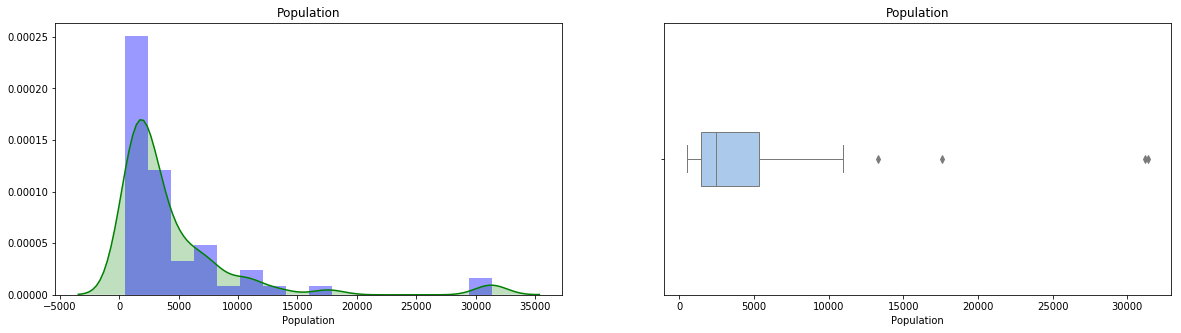

In [13]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(121)
sns.distplot(features['Population'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population')

fig.add_subplot(122)
sns.boxplot(features['Population'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Population')

In [14]:
print(np.sort(features.Population)[-10:])

[ 7709.  7834.  8425. 10517. 10664. 10952. 13308. 17589. 31207. 31406.]


In [15]:
features['Population'] = features[features.Population < 17000.0]
features = features.dropna(subset=['Population'])

In [16]:
features['Population_log'] = np.log(features['Population'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Population')

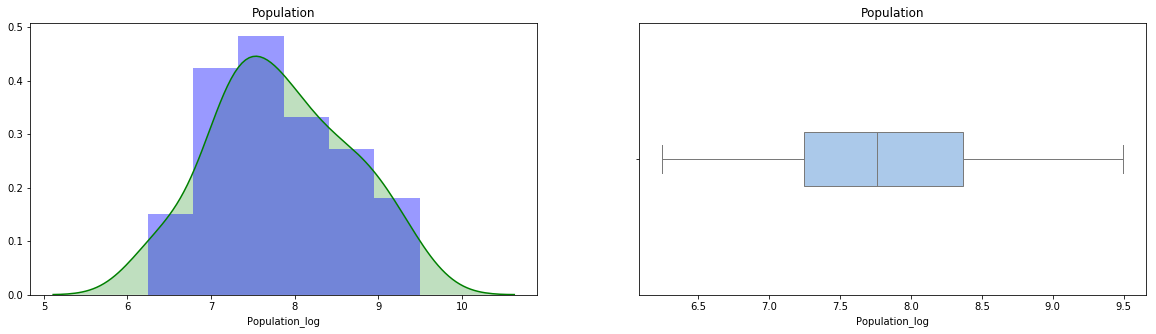

In [17]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(121)
sns.distplot(features['Population_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population')

fig.add_subplot(122)
sns.boxplot(features['Population_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Population')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Robbery_raw')

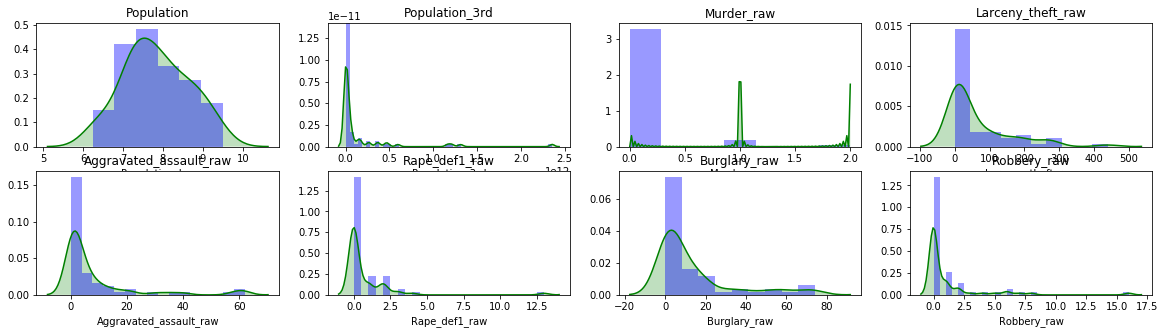

In [18]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(241)
sns.distplot(features['Population_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population')

fig.add_subplot(242)
sns.distplot(features['Population_3rd'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population_3rd')

fig.add_subplot(243)
sns.distplot(features['Murder_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Murder_raw')

fig.add_subplot(244)
sns.distplot(features['Larceny_theft_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Larceny_theft_raw')

fig.add_subplot(245)
sns.distplot(features['Aggravated_assault_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Aggravated_assault_raw')

fig.add_subplot(246)
sns.distplot(features['Rape_def1_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Rape_def1_raw')

fig.add_subplot(247)
sns.distplot(features['Burglary_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Burglary_raw')

fig.add_subplot(248)
sns.distplot(features['Robbery_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Robbery_raw')

***Murder, Rape1 and Robbery should be kept as binary categorical***

In [19]:
features['Population_3rd_log'] = np.log(features['Population_3rd'])
features['Larceny_theft_log'] = np.log(features['Larceny_theft_raw'])
features['Aggravated_assault_log'] = np.log(features['Aggravated_assault_raw'])
features['Burglary_log'] = np.log(features['Burglary_raw'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0.5,1,'Burglary_log')

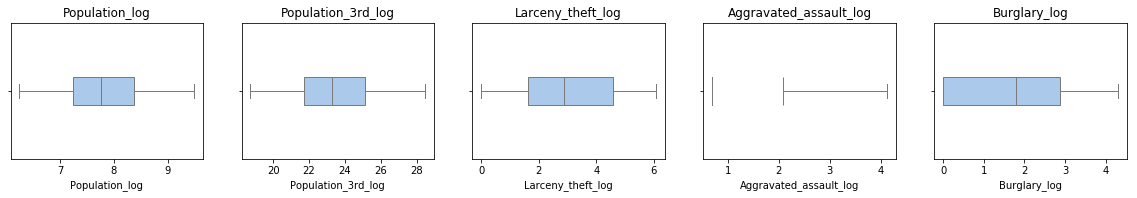

In [20]:
fig = plt.figure(figsize=(20,2.5))

fig.add_subplot(151)
sns.boxplot(features['Population_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Population_log')

fig.add_subplot(152)
sns.boxplot(features['Population_3rd_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Population_3rd_log')

fig.add_subplot(153)
sns.boxplot(features['Larceny_theft_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Larceny_theft_log')

fig.add_subplot(154)
sns.boxplot(features['Aggravated_assault_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Aggravated_assault_log')

fig.add_subplot(155)
sns.boxplot(features['Burglary_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Burglary_log')

In [21]:
# Checking for '-inf' after log transformations...

features[features == np.inf].sum()
features[features == -np.inf].sum()

Population                0.000000
Murder_raw                0.000000
Larceny_theft_raw         0.000000
Aggravated_assault_raw    0.000000
Burglary_raw              0.000000
Rape_def1_raw             0.000000
Robbery_raw               0.000000
Property_Crime            0.000000
Murder                    0.000000
Larceny_theft             0.000000
Aggravated_assault        0.000000
Burglary                  0.000000
Rape_def1                 0.000000
Robbery                   0.000000
Population_3rd            0.000000
Population_log            0.000000
Population_3rd_log        0.000000
Larceny_theft_log             -inf
Aggravated_assault_log        -inf
Burglary_log                  -inf
dtype: float64

In [22]:
features['Larceny_theft_log'] = features['Larceny_theft_log'].replace([np.inf, -np.inf], np.nan)
features = features.dropna(subset=['Larceny_theft_log'])
features['Aggravated_assault_log'] = features['Aggravated_assault_log'].replace([np.inf, -np.inf], np.nan)
features = features.dropna(subset=['Aggravated_assault_log'])
features['Burglary_log'] = features['Burglary_log'].replace([np.inf, -np.inf], np.nan)
features = features.dropna(subset=['Burglary_log'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Burglary_log')

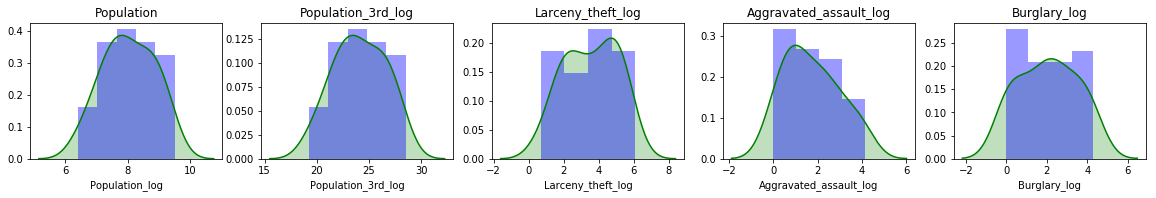

In [23]:
fig = plt.figure(figsize=(20,2.5))

fig.add_subplot(151)
sns.distplot(features['Population_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population')

fig.add_subplot(152)
sns.distplot(features['Population_3rd_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population_3rd_log')

fig.add_subplot(153)
sns.distplot(features['Larceny_theft_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Larceny_theft_log')

fig.add_subplot(154)
sns.distplot(features['Aggravated_assault_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Aggravated_assault_log')

fig.add_subplot(155)
sns.distplot(features['Burglary_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Burglary_log')

Text(0.5,1,'Burglary_log')

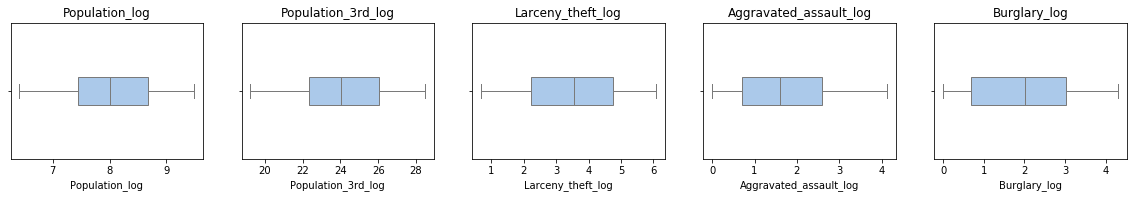

In [24]:
fig = plt.figure(figsize=(20,2.5))

fig.add_subplot(151)
sns.boxplot(features['Population_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Population_log')

fig.add_subplot(152)
sns.boxplot(features['Population_3rd_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Population_3rd_log')

fig.add_subplot(153)
sns.boxplot(features['Larceny_theft_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Larceny_theft_log')

fig.add_subplot(154)
sns.boxplot(features['Aggravated_assault_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Aggravated_assault_log')

fig.add_subplot(155)
sns.boxplot(features['Burglary_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Burglary_log')

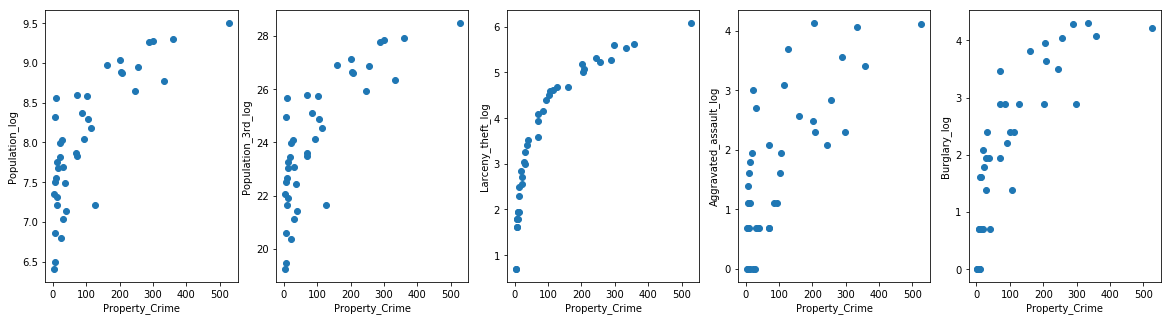

In [25]:
# Linear Relationship

fig = plt.figure(figsize=(20,5))

fig.add_subplot(151)
plt.scatter(features['Property_Crime'],features['Population_log'])
plt.ylabel('Population_log')
plt.xlabel('Property_Crime')

fig.add_subplot(152)
plt.scatter(features['Property_Crime'],features['Population_3rd_log'])
plt.ylabel('Population_3rd_log')
plt.xlabel('Property_Crime')

fig.add_subplot(153)
plt.scatter(features['Property_Crime'],features['Larceny_theft_log'])
plt.ylabel('Larceny_theft_log')
plt.xlabel('Property_Crime')

fig.add_subplot(154)
plt.scatter(features['Property_Crime'],features['Aggravated_assault_log'])
plt.ylabel('Aggravated_assault_log')
plt.xlabel('Property_Crime')

fig.add_subplot(155)
plt.scatter(features['Property_Crime'],features['Burglary_log'])
plt.ylabel('Burglary_log')
plt.xlabel('Property_Crime')

plt.show()

In [42]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
y = features['Property_Crime']
X = features[['Population_3rd_log','Aggravated_assault_log','Robbery','Rape_def1']]
regr.fit(X, y)

# 'Population_log'
# 'Population_3rd_log'
# 'Larceny_theft_log'
# 'Aggravated_assault_log'
# 'Burglary_log'
# 'Robbery'
# 'Murder'
# 'Rape_def1'

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, y))


Coefficients: 
 [23.3851636  41.2016033  18.99387359 23.65404694]

Intercept: 
 -546.6036243216265

R-squared:
0.7342971302338519


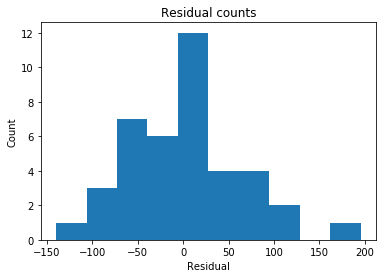

In [43]:
# Multivariate Normality

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = features['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

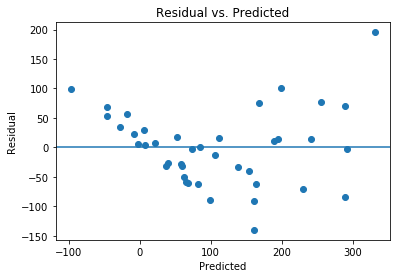

In [44]:
# Homoscedasticity

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [29]:
# Multicollinearity

correlation_matrix = X.corr()
display(correlation_matrix)

,Population_3rd_log,Aggravated_assault_log,Robbery,Rape_def1
Population_3rd_log,1.000000,0.630864,0.236954,0.471131
Aggravated_assault_log,0.630864,1.000000,0.161779,0.301536
Robbery,0.236954,0.161779,1.000000,0.337350
Rape_def1,0.471131,0.301536,0.337350,1.000000


# Test Statistics

In [33]:
linear_formula = 'Property_Crime ~ Population_3rd_log+Aggravated_assault_log+Robbery+Rape_def1'
lm = smf.ols(formula=linear_formula, data=features).fit()
print(lm.params)
print('\n')
print(lm.pvalues)
print('\n')
print(lm.rsquared)
print(lm.conf_int())

Intercept                -522.444270
Population_3rd_log         22.378144
Aggravated_assault_log     41.966373
Robbery                    13.080460
Murder                     40.920379
Rape_def1                  16.590557
dtype: float64


Intercept                 0.000534
Population_3rd_log        0.001036
Aggravated_assault_log    0.000709
Robbery                   0.585588
Murder                    0.332291
Rape_def1                 0.542842
dtype: float64


0.7416475905471474
                                 0           1
Intercept              -800.044745 -244.843795
Population_3rd_log        9.703610   35.052678
Aggravated_assault_log   19.064362   64.868383
Robbery                 -35.209377   61.370297
Murder                  -43.631865  125.472624
Rape_def1               -38.258644   71.439757


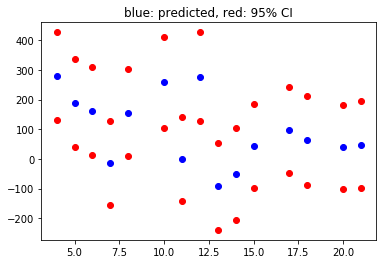

In [34]:
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

# Linear Regression - Cross Validation

In [32]:
X = features[['Population_3rd_log','Aggravated_assault_log','Robbery','Rape_def1']]
y = features['Property_Crime']

linear_regression = linear_model.LinearRegression()
print(cross_val_score(linear_regression, X, y, cv=3))

[-0.13225959  0.17565347  0.69515832]


# Write Up

Rape appeared to solve for homoscedasticity and explain a good degree of variance while not correlating closely with other features. Burglary, larceny and assault were generally correlated with eachother. 

It is still difficult to gain consistancy in the accuracy of model across folds due to the high variance of the population itself. Even after removing outliers and normalizing, there would likely need to be two models based around large and small populations. This manifests in the coefficients and p-values for binary categorical features (> .05). Confidence intervals reflect the same issues where binary categorical features contain 0, not explaining ignificant variance in the outcome, and confidence intervals overall are particularly wide.

I chose 3-fold linear regression cross validation as the dataset is relatively small. If there were a large amount of data which required more heavy lifting from the program, I would have used LOOCV, the Leave One Out Cross Validation method.